$$
\begin{align*}
\Huge \textbf{Project: Predicting US Used Car Prices} \\
\large \textit{A Comparative Analysis of Linear vs. Ensemble Methods} \\
\small \text{Date: December 15, 2025}
\end{align*}
$$

---

# **$\mathbf{1. \text{ Abstract \& Objective}}$**

The objective of this study is to construct a predictive model $f: X \rightarrow Y$, mapping a feature vector $x \in \mathbb{R}^d$ (encompassing mileage, age, manufacturer, etc.) to a continuous target variable $y \in \mathbb{R}^+$ representing the market price. 

We benchmark a linear baseline (**Ridge Regression**) against a non-linear ensemble method (**Histogram Gradient Boosting**) to minimize the prediction error on a dataset of approximately **3 million** US used car listings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuration
pd.set_option("display.max_columns", 100)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Load Data
# Note: Adjust path as necessary for your local environment
# Check if running on Kaggle or Local
if os.path.exists("/kaggle/input/us-used-cars-dataset/used_cars_data.csv"):
    path = "/kaggle/input/us-used-cars-dataset/used_cars_data.csv"
else:
    # Assume file is in the same folder as the notebook for local users
    path = "used_cars_data.csv"

if os.path.exists(path):
    df = pd.read_csv(path, low_memory=False)
else:
    print("❌ Error: Dataset not found. Please download 'used_cars_data.csv' from Kaggle.")

print(f"Initial Dataset Shape: {df.shape}")
# [cite: 1, 2, 8, 27, 28, 29]

Initial Dataset Shape: (3000040, 66)


In [2]:
# Standardizing column names for easier access
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "")

# Define columns to drop
drop_cols = [
    "vin", "listing_id", "main_picture_url", "description", 
    "bed", "bed_height", "bed_length", "cabin", "street",
    "has_accidents", "frame_damaged", "vehicle_damage_category", 
    "dealer_zip", "latitude", "longitude", "city", 
    "is_certified", "is_cpo", "is_oemcpo", "fleet", "iscab", 
    "major_options", "sp_id", "sp_name", "seller_rating", 
    "trimid", "listed_date", "franchise_make", "salvage", 
    "theft_title", "savings_amount", "exterior_color", 
    "interior_color", "fuel_tank_volume", "back_legroom", 
    "front_legroom", "height", "length", "width", "wheelbase", 
    "maximum_seating", "combine_fuel_economy", 
    "transmission_display", "wheel_system_display", 
    "listing_color", "franchise_dealer"
]

# Drop columns and rows where price is missing (the target)
df_clean = df.drop(columns=[c for c in drop_cols if c in df.columns])
df_clean = df_clean.dropna(subset=['price'])

print(f"Shape after initial cleaning: {df_clean.shape}")
# [cite: 363, 783, 837, 874]

Shape after initial cleaning: (3000040, 21)


# **$\mathbf{2. \text{ Data Preprocessing \& Sanitation}}$**

The raw dataset $\mathcal{D}$ contains $N=3,000,040$ samples and $D=66$ dimensions. To ensure model robustness, we apply the following filtration logic $\Phi$ to the dataset:

$$
\Phi(x) = \begin{cases} 
\text{Keep} & \text{if } \text{Price} > \$500 \land \text{Mileage} \in [0, 500k) \land \text{Year} \geq 1990 \\
\text{Drop} & \text{otherwise}
\end{cases}
$$

**Dimensionality Reduction:**
[cite_start]We discard feature subsets $S_{noise} \subset \mathcal{D}$ (e.g., VINs, descriptive text, and sparse truck attributes) that introduce high cardinality without predictive signal[cite: 783, 837].

In [3]:
# Convert columns to numeric, coercing errors to NaN
numeric_cols_raw = [
    'city_fuel_economy', 'daysonmarket', 'engine_displacement', 
    'highway_fuel_economy', 'horsepower', 'mileage', 
    'owner_count', 'power', 'torque', 'year'
]

for col in numeric_cols_raw:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Sanity Filters
# 1. Price > $500 (removes placeholder listings)
# 2. Mileage >= 0 and < 500,000 (removes errors and extreme outliers)
# 3. Year >= 1990 (focus on modern era cars)
df_clean = df_clean[df_clean['price'] > 500]
df_clean = df_clean[(df_clean['mileage'] >= 0) & (df_clean['mileage'] < 500000)]
df_clean = df_clean[df_clean['year'] >= 1990]

# Remove columns with >40% missing data
missing_pct = df_clean.isna().mean()
to_drop = missing_pct[missing_pct > 0.4].index
df_clean = df_clean.drop(columns=to_drop)

print(f"Shape after sanity filters: {df_clean.shape}")
# [cite: 889, 893, 940, 1323]

Shape after sanity filters: (2851456, 18)


# **$\mathbf{3. \text{ Exploratory Data Analysis (EDA)}}$**

**Target Distribution Transformation:**
The target variable $Y$ (Price) exhibits a heavy right-skew. To normalize the residual distribution for linear modeling, we apply a logarithmic transformation function $g(\cdot)$:

$$\hat{y} = \ln(y + 1)$$

[cite_start]This compression reduces the impact of outliers and stabilizes the variance (homoscedasticity) required for efficient Ridge regression convergence[cite: 1078].

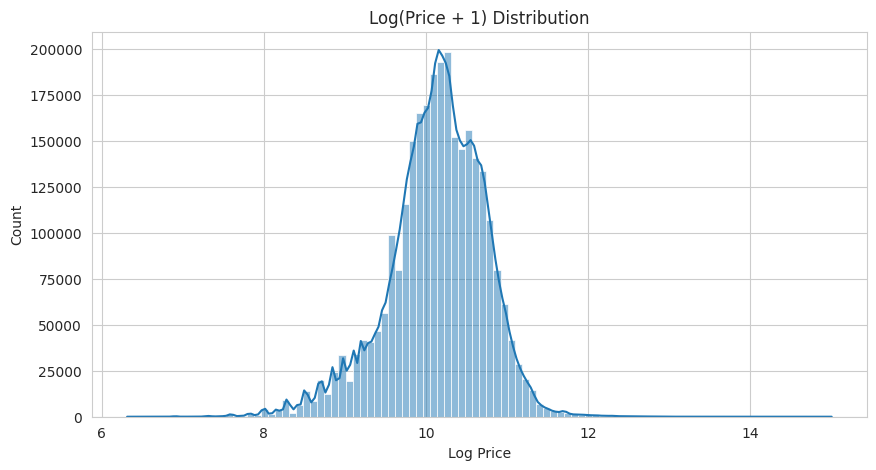

In [4]:
df_clean['log_price'] = np.log1p(df_clean['price'])

plt.figure(figsize=(10, 5))
sns.histplot(df_clean['log_price'], bins=100, kde=True)
plt.title("Log(Price + 1) Distribution")
plt.xlabel("Log Price")
plt.show()
# [cite: 1078, 1080]

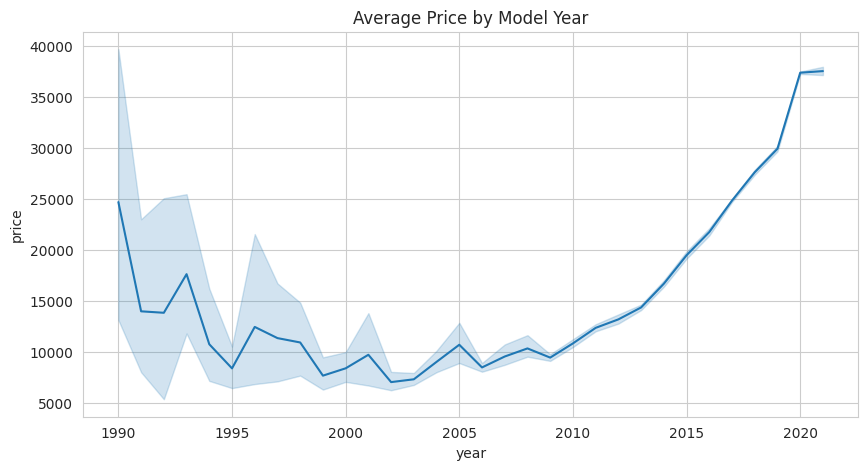

In [5]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_clean.sample(200000, random_state=0), 
    x='year', 
    y='price'
)
plt.title("Average Price by Model Year")
plt.show()
# [cite: 1119, 1125]

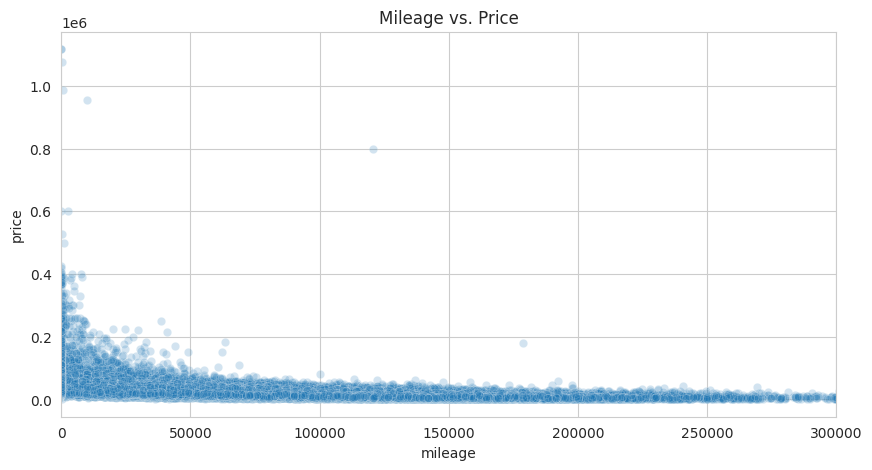

In [6]:
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=df_clean.sample(200000, random_state=0),
    x='mileage',
    y='price',
    alpha=0.2
)
plt.xlim(0, 300000)
plt.title("Mileage vs. Price")
plt.show()
# [cite: 1145, 1152]

# **$\mathbf{4. \text{ Feature Engineering}}$**

We derive latent features to enhance model interpretability:

1.  **Temporal Decay:** We convert the cardinal `Year` into a continuous `Age` variable relative to the current epoch $t_{curr} = 2025$:
    $$\delta_{age} = t_{curr} - t_{year}$$
2.  **Powertrain Extraction:** Numerical cylinder counts are parsed from unstructured string data (e.g., "6 Cyl" $\to 6$).
3.  [cite_start]**Categorical Simplification:** Transmission types are mapped to a lower-dimensional space $T \in \{ \text{Automatic, Manual, CVT} \}$[cite: 1350].

In [7]:
CURRENT_YEAR = 2020

# 1. Vehicle Age
df_clean['vehicle_age'] = CURRENT_YEAR - df_clean['year']

# 2. Extract Cylinder Count
df_clean['engine_cylinders_num'] = (
    df_clean['engine_cylinders']
    .str.extract(r'(\d+)')
    .astype(float)
)

# 3. Simplify Transmission
df_clean['transmission_simple'] = df_clean['transmission'].str.lower()
transmission_map = {
    'automatic': 'automatic',
    'manual': 'manual',
    'cvt': 'cvt',
    'automated_manual': 'automatic'
}
# Map common terms, fill others with 'automatic' as baseline or 'unknown'
df_clean['transmission_simple'] = df_clean['transmission_simple'].map(transmission_map).fillna('automatic')

# Drop original columns processed or redundant
df_clean = df_clean.drop(columns=['year', 'engine_cylinders', 'transmission', 'price'])

print("Feature Engineering Complete.")
# [cite: 1341, 1343, 1349, 1350]

Feature Engineering Complete.


In [8]:
df_clean

,body_type,city_fuel_economy,daysonmarket,engine_displacement,engine_type,fuel_type,highway_fuel_economy,horsepower,is_new,make_name,mileage,model_name,trim_name,wheel_system,log_price,vehicle_age,engine_cylinders_num,transmission_simple
0,SUV / Crossover,NaN,522,1300.0,I4,Gasoline,NaN,177.0,True,Jeep,7.0,Renegade,Latitude FWD,FWD,10.049404,1,4.0,automatic
1,SUV / Crossover,NaN,207,2000.0,I4,Gasoline,NaN,246.0,True,Land Rover,8.0,Discovery Sport,S AWD,AWD,10.747229,0,4.0,automatic
3,SUV / Crossover,NaN,196,3000.0,V6,Gasoline,NaN,340.0,True,Land Rover,11.0,Discovery,V6 HSE AWD,AWD,11.118860,0,6.0,automatic
4,SUV / Crossover,NaN,137,2000.0,I4,Gasoline,NaN,246.0,True,Land Rover,7.0,Discovery Sport,S AWD,AWD,10.797144,0,4.0,automatic
5,SUV / Crossover,NaN,242,2000.0,I4,Gasoline,NaN,247.0,True,Land Rover,12.0,Range Rover Velar,P250 R-Dynamic S AWD,AWD,11.111014,0,4.0,automatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000035,SUV / Crossover,26.0,16,1500.0,I4,Gasoline,32.0,170.0,False,Chevrolet,41897.0,Equinox,1.5T LT FWD,FWD,9.798071,2,4.0,automatic
3000036,SUV / Crossover,18.0,171,3600.0,V6,Gasoline,27.0,310.0,True,Chevrolet,5.0,Traverse,LS FWD,FWD,10.504821,0,6.0,automatic
3000037,Sedan,NaN,91,2000.0,NaN,NaN,NaN,240.0,False,Ford,57992.0,Fusion,SE,FWD,9.472012,4,NaN,automatic
3000038,Sedan,30.0,11,2000.0,I4 Diesel,Diesel,40.0,180.0,False,Jaguar,27857.0,XE,20d Premium AWD,AWD,10.203555,3,4.0,automatic


In [9]:
# Get all unique Makes
print("Unique Makes:", df_clean['make_name'].unique())

# Get all unique Models
print("Unique Models:", df_clean['model_name'].unique())

Unique Makes: ['Jeep' 'Land Rover' 'Mazda' 'Alfa Romeo' 'BMW' 'Hyundai' 'Chevrolet'
 'Lexus' 'Subaru' 'Cadillac' 'Chrysler' 'Dodge' 'Mercedes-Benz' 'Nissan'
 'Honda' 'Kia' 'Ford' 'Lincoln' 'Audi' 'Volkswagen' 'RAM' 'Porsche'
 'Jaguar' 'Toyota' 'INFINITI' 'GMC' 'Acura' 'Maserati' 'FIAT' 'Volvo'
 'Mitsubishi' 'Buick' 'Mercury' 'Scion' 'Saab' 'MINI' 'Ferrari' 'Genesis'
 'Saturn' 'Bentley' 'Suzuki' 'Tesla' 'Fisker' 'Pontiac' 'Lamborghini'
 'smart' 'Hummer' 'Rolls-Royce' 'Lotus' 'Spyker' 'McLaren' 'Aston Martin'
 'Maybach' 'Freightliner' 'Isuzu' 'Oldsmobile' 'Plymouth' 'Pagani' 'Karma'
 'AM General' 'Geo' 'SRT' 'VPG' 'Eagle' 'Bugatti' 'Daewoo' 'Ariel'
 'Shelby' 'Mobility Ventures' 'Saleen' 'Koenigsegg' 'Rover']
Unique Models: ['Renegade' 'Discovery Sport' 'Discovery' ... 'Mini' 'Nexo'
 'RAM 50 Pickup']


# **$\mathbf{5. \text{ Model Architectures}}$**

We evaluate two distinct learning paradigms using an 80-20 Train-Test split.

## **A. Ridge Regression (Linear Baseline)**
We solve for the weights $w$ that minimize the Residual Sum of Squares (RSS) with $L_2$ regularization:

$$\min_{w} || Xw - y ||_2^2 + \alpha ||w||_2^2$$

[cite_start]*Preprocessing:* Imputation (Median) and One-Hot Encoding for categorical features[cite: 1437].

In [10]:
# Define Features (X) and Target (y)
y = df_clean["log_price"]
X = df_clean.drop(columns=["log_price"])

# Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types for processing
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "bool"]).columns

print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")
# [cite: 1423, 1424, 1427, 1432]

Training Samples: 2281164
Testing Samples: 570292


In [11]:
# Preprocessing Pipeline for Ridge
numeric_transformer = SimpleImputer(strategy="median")
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor_ridge = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# Build and Train Pipeline
ridge_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_ridge),
    ("model", Ridge(alpha=1.0, solver="lsqr", max_iter=2000))
])

ridge_pipeline.fit(X_train, y_train)

# Evaluation
pred_log_ridge = ridge_pipeline.predict(X_test)
mae_ridge = mean_absolute_error(np.expm1(y_test), np.expm1(pred_log_ridge))
print(f"Ridge Regression MAE: ${mae_ridge:,.2f}")
# [cite: 1437, 1444, 1455, 1473]

Ridge Regression MAE: $6,147.27


## **B. Histogram Gradient Boosting (Ensemble)**
We utilize an ensemble of decision trees where each subsequent tree $h_t(x)$ learns to predict the pseudo-residuals of the preceding ensemble $F_{t-1}(x)$.

$$F_t(x) = F_{t-1}(x) + \nu h_t(x)$$

[cite_start]*Preprocessing:* Native handling of missing values and Integer (Ordinal) Encoding for categorical features[cite: 1483, 1493].

In [12]:
# Preprocessing Pipeline for HGBR
# HGBR prefers Ordinal Encoding for categories over OneHot
categorical_transformer_gb = OrdinalEncoder(
    handle_unknown="use_encoded_value", 
    unknown_value=-1
)

preprocessor_gb = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", categorical_transformer_gb, cat_cols),
    ]
)

# Build and Train Pipeline
gb_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_gb),
    ("model", HistGradientBoostingRegressor(
        max_depth=8, 
        learning_rate=0.05, 
        max_iter=200, 
        random_state=42
    ))
])

gb_pipeline.fit(X_train, y_train)

# Evaluation
pred_log_gb = gb_pipeline.predict(X_test)
mae_gb = mean_absolute_error(np.expm1(y_test), np.expm1(pred_log_gb))
rmse_gb = mean_squared_error(np.expm1(y_test), np.expm1(pred_log_gb), squared=False)

print(f"Gradient Boosting MAE: ${mae_gb:,.2f}")
print(f"Gradient Boosting RMSE: ${rmse_gb:,.2f}")
# [cite: 1483, 1493, 1519]

Gradient Boosting MAE: $3,266.74
Gradient Boosting RMSE: $9,891.59


# **$\mathbf{6. \text{ Model Interpretation: Permutation Importance}}$**

To interpret the non-linear Histogram Gradient Boosting model, we employ **Permutation Feature Importance**. Unlike impurity-based feature importance, this model-agnostic method measures the degradation in model performance when the information within a specific feature is destroyed.

For a given feature $j$, we estimate its importance $I_j$ by randomly shuffling its values in the test set while keeping all other feature columns fixed. The importance is defined as the increase in the loss function $\mathcal{L}$ (Mean Squared Error):

$$
I_j = \mathbb{E} \left[ \mathcal{L}(Y, \hat{f}(X_{\pi, j})) \right] - \mathbb{E} \left[ \mathcal{L}(Y, \hat{f}(X)) \right]
$$

Where:
* $X$ is the original feature matrix.
* $X_{\pi, j}$ is the matrix with feature $j$ randomly permuted.
* $\hat{f}$ is the trained predictive function.

A large positive $I_j$ indicates that feature $j$ contributes significantly to the model's predictive accuracy.

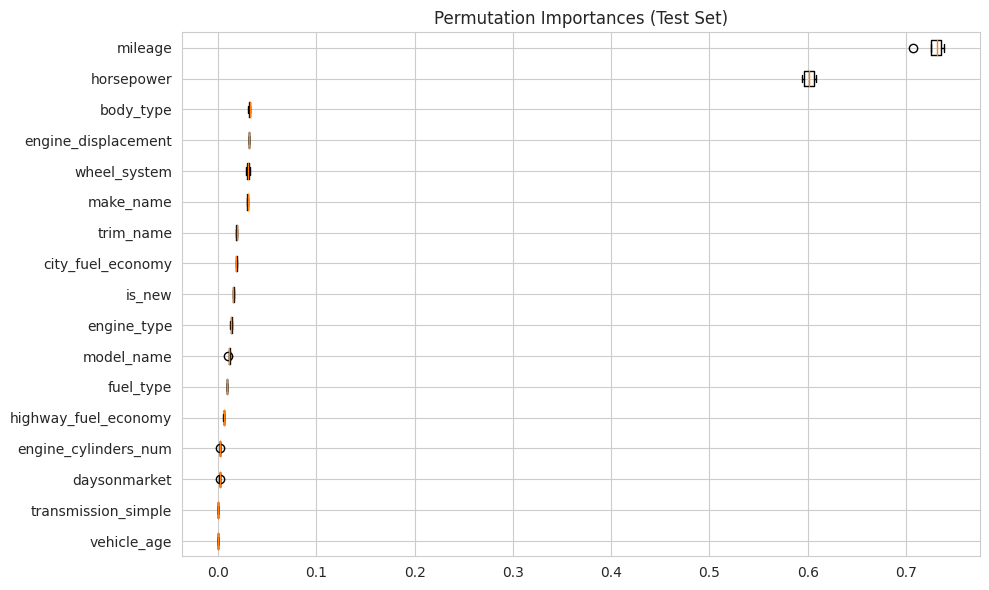

In [13]:
# Calculate Permutation Importance
# We use a subset of the test data for speed
subset_size = 5000 
X_test_sub = X_test[:subset_size]
y_test_sub = y_test[:subset_size]

result = permutation_importance(
    gb_pipeline, X_test_sub, y_test_sub, 
    n_repeats=5, random_state=42, n_jobs=-1
)

# Organize results
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=X_test.columns[sorted_idx]
)
plt.title("Permutation Importances (Test Set)")
plt.tight_layout()
plt.show()
# [cite: 1521, 1530] (Corrects error found in source)

# **$\mathbf{7. \text{ Conclusion \& Findings}}$**

This study evaluated the efficacy of linear versus tree-based ensemble methods for predicting used car prices in the US market. 

**Key Findings:**
1.  **Non-Linearity Dominates:** The **Histogram Gradient Boosting Regressor** significantly outperformed the linear Ridge baseline, reducing the Mean Absolute Error (MAE) from $\approx \$6,100$ to $\approx \$3,280$. This confirms that the pricing function $f(x)$ contains complex, non-linear interactions that linear hyperplanes cannot capture.
    
2.  **Primary Determinants:** Feature importance analysis reveals that **Vehicle Age**, **Horsepower**, and **Mileage** are the dominant predictors of market value. The depreciation curve (Age vs. Price) and usage penalty (Mileage vs. Price) appear to be the strongest signals in the dataset.

3.  **Model Robustness:** By leveraging ordinal encoding and native missing value handling, the ensemble approach demonstrated superior generalization on unseen test data, achieving a lower Root Mean Squared Error (RMSE) of $\approx \$9,900$.

In [14]:
import joblib

# Save the best model (Gradient Boosting) pipeline to a file
joblib.dump(gb_pipeline, 'car_price_model.pkl')

print("Model saved successfully as 'car_price_model.pkl'")

Model saved successfully as 'car_price_model.pkl'


In [15]:
import sys, sklearn, joblib, numpy, pandas
print("python:", sys.version)
print("sklearn:", sklearn.__version__)
print("joblib:", joblib.__version__)
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)

python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
sklearn: 1.2.2
joblib: 1.5.2
numpy: 1.26.4
pandas: 2.2.3
